# Slurm in 2021

# TODO

* everything in Seaborn plots (number of jobs per partition, job runtime per partition, per weekday, job submissions, job per node, jobtime per node, capacity)
* some new fields added , should be at beginning ("AllocatedCPUTime")

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import re
import seaborn as sns

from matplotlib.ticker import FuncFormatter

In [2]:
INPUT_FILE = "sacct_20211220.csv"

In [3]:
sns.set_theme(
    context='talk',
    style="white",
)
    
plt.rcParams["figure.figsize"] = (16, 9)

In [4]:
# 16-01:02:03.456 means 16 days, 01 hours, 02 minutes, 03 seconds, 456 nanoseconds
delta_with_days = re.compile(r"(?P<days>\d+)-(?P<hours>[\d:]+)")  # dd-hh:mm:ss
delta_with_ns = re.compile(r"\d\d:\d\d\.\d+")  # mm:ss.nnnnnnn

def normalize(x):
    m_days = delta_with_days.search(x)
    m_ns = delta_with_ns.search(x)
    
    if m_ns is not None:
        return f"00:{x}"
    
    if m_days is not None:
        return f"{m_days.group('days')} days {m_days.group('hours')}"
    
    return x

In [5]:
# AllocTRES: billing=2,cpu=2,gres/gpu=1,mem=64G,node=1  or  billing=2,cpu=2,mem=4G,node=1
gpus = re.compile(r"gres/gpu=(?P<nbgpus>\d+)")

def nb_allocated_gpus(x):
    if not isinstance(x, str):
        return 0
    m = gpus.search(x)
    if m is None:
        return 0
    return int(m.group("nbgpus"))

In [6]:
# AllocTRES: billing=2,cpu=2,gres/gpu=1,mem=64G,node=1  or  billing=2,cpu=2,mem=4G,node=1
ram = re.compile(r"mem=(?P<ram>\d+)G")

def amount_ram(x):
    if not isinstance(x, str):
        return 0
    m = ram.search(x)
    if m is None:
        return 0
    return int(m.group("ram"))

In [7]:
original = pd.read_csv(INPUT_FILE, sep="|")

In [8]:
df = original.dropna(axis=0, subset=["User"]).copy(deep=True)

In [9]:
df.columns

Index(['User', 'JobID', 'JobName', 'JobIDRaw', 'Partition', 'State',
       'Timelimit', 'Submit', 'Start', 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize',
       'NNodes', 'NCPUS', 'NodeList', 'AllocTRES', 'TotalCPU'],
      dtype='object')

In [10]:
df["count"] = 1
df["Start"] = pd.to_datetime(df["Start"], format="%Y-%m-%dT%H:%M:%S", errors="coerce")
df = df[df["Start"].dt.year == 2021].copy(deep=True)

df["Submit"] = pd.to_datetime(df["Submit"], format="%Y-%m-%dT%H:%M:%S", errors="coerce")
df["Wait-M"] = (df["Start"] - df["Submit"]).dt.total_seconds() / 60.0

In [11]:
df["Elapsed-S"] = pd.to_timedelta(df["Elapsed"].apply(normalize))
df["Elapsed-H"] = df["Elapsed-S"].dt.total_seconds() / 3600.0

In [12]:
df["AllocatedGPUs"] = df["AllocTRES"].apply(nb_allocated_gpus)

In [13]:
df["AllocatedRAM"] = df["AllocTRES"].apply(amount_ram)

In [14]:
cpu_bins = [2 ** i for i in range(9)]
cpu_labels= [str(b) for b in cpu_bins[1:]]
df["CPUCat"] = pd.cut(df["NCPUS"], bins=cpu_bins, labels=cpu_labels)

In [15]:
ram_bins = [2 ** i for i in range(9)]
ram_labels= [str(b) for b in ram_bins[1:]]
df["RAMCat"] = pd.cut(df["AllocatedRAM"], bins=ram_bins, labels=ram_labels)

In [16]:
gpu_bins = [-1, 0, 1, 2, 3, 4, 100]
gpu_labels = ["No GPU", "1", "2", "3", "4", "> 4"]
df["GPUCat"] = pd.cut(df["AllocatedGPUs"], bins=gpu_bins, labels=gpu_labels)

In [17]:
df["Date"] = df["Start"].dt.floor(freq="D") 
df["Month"] = df["Start"].dt.month
df["DayNumber"] = df["Start"].dt.day
df["Day"] = df["Start"].dt.day_name()
df["Hour"] = df["Start"].dt.hour

In [18]:
df["StateTag"] = df["State"].apply(lambda x: x.split()[0])

In [19]:
tab20 = plt.get_cmap("tab20")

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
days_colors = {day : tab20(i) for i, day in enumerate(days)}
days_colors_list = [tab20(i) for i, _ in enumerate(days)]

partitions = ["cpu", "gpu"]
partitions_colors = {p: tab20(4 * i) for i, p in enumerate(partitions)}
partitions_colors_list = [tab20(4 * i) for i in range(len(partitions))]

In [20]:
df.columns

Index(['User', 'JobID', 'JobName', 'JobIDRaw', 'Partition', 'State',
       'Timelimit', 'Submit', 'Start', 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize',
       'NNodes', 'NCPUS', 'NodeList', 'AllocTRES', 'TotalCPU', 'count',
       'Wait-M', 'Elapsed-S', 'Elapsed-H', 'AllocatedGPUs', 'AllocatedRAM',
       'CPUCat', 'RAMCat', 'GPUCat', 'Date', 'Month', 'DayNumber', 'Day',
       'Hour', 'StateTag'],
      dtype='object')

# Number of Jobs per Partition

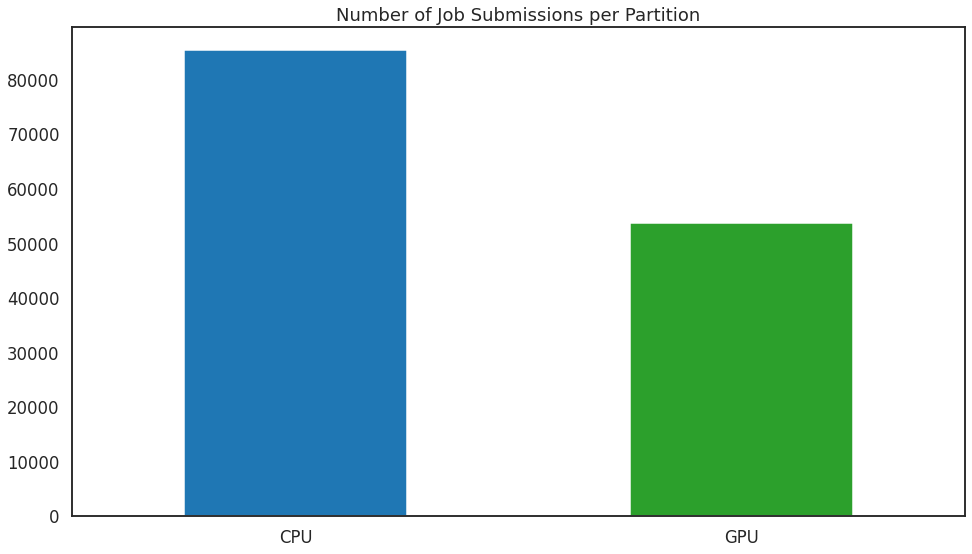

In [21]:
by_partition = _ = df[df["Partition"].isin(partitions)].groupby("Partition").count()["JobID"]
by_partition.plot.bar(color=[partitions_colors[p] for p in by_partition.index.get_level_values("Partition")], xlabel="")
_ = plt.gca().set_xticklabels(by_partition.index.get_level_values("Partition").str.upper(), rotation=0)
_ = plt.title("Number of Job Submissions per Partition")

plt.savefig("job_per_partition.pdf", bbox_inches="tight")

# Job Runtime per Partition

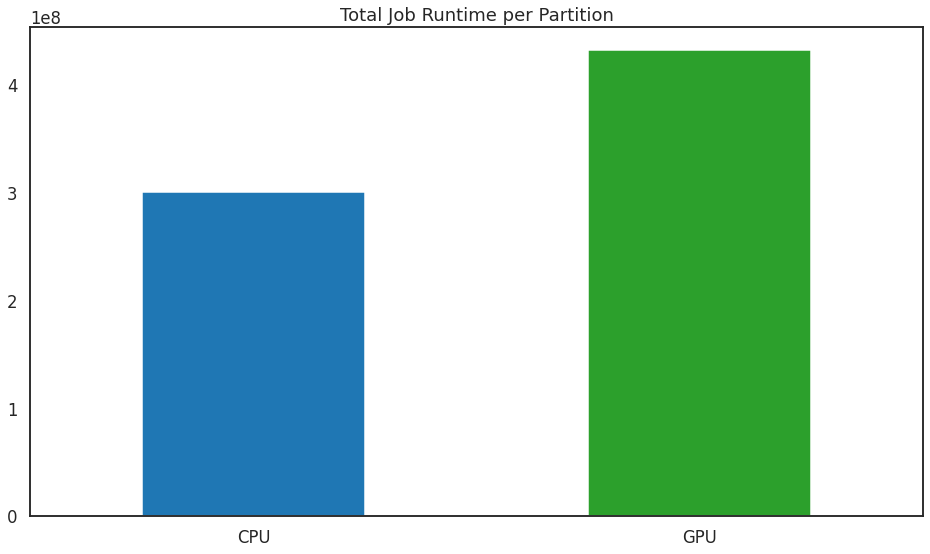

In [22]:
by_partition = _ = df[df["Partition"].isin(partitions)].groupby("Partition")["Elapsed-S"].sum()
by_partition.dt.total_seconds().plot.bar(color=[partitions_colors[p] for p in by_partition.index.get_level_values("Partition")], xlabel="")
_ = plt.gca().set_xticklabels(by_partition.index.get_level_values("Partition").str.upper(), rotation=0)
_ = plt.title("Total Job Runtime per Partition")
plt.savefig("job_runtime_per_partition.pdf", bbox_inches="tight")

# Completed Jobs Runtime

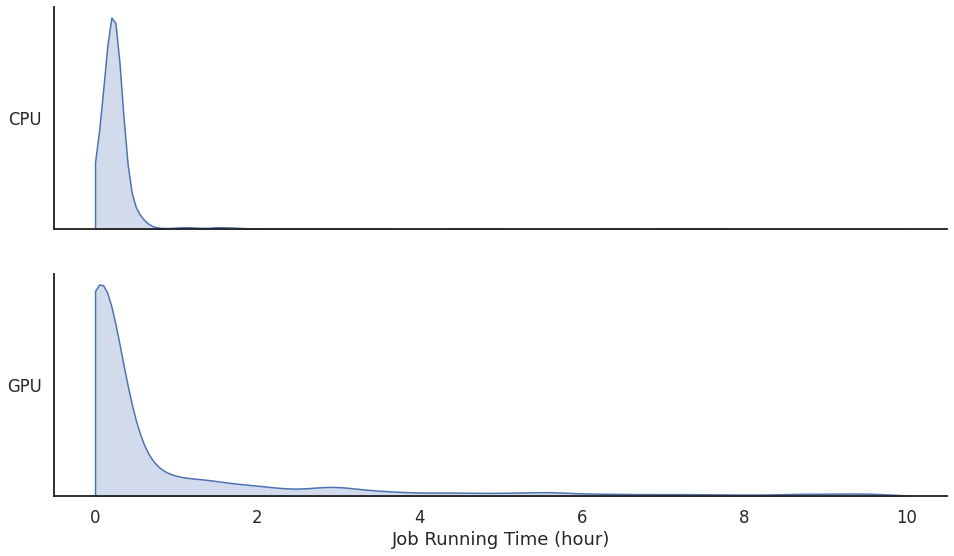

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)

focus = df[(df["State"] == "COMPLETED") & (df["Elapsed-H"] <= 10)]
data_cpu = focus[focus["Partition"] == "cpu"]
data_gpu = focus[focus["Partition"] == "gpu"]

sns.kdeplot(x="Elapsed-H", data=data_cpu, fill=True, ax=axs[0], linewidth=1.5, cut=0)
lim = axs[0].get_ylim()
axs[0].set_yticks([(lim[0] + lim[1]) / 2])
axs[0].set_yticklabels(["CPU"])
#axs[0].spines["bottom"].set_visible(False)

sns.kdeplot(x="Elapsed-H", data=data_gpu, fill=True, ax=axs[1], linewidth=1.5, cut=0)
lim = axs[1].get_ylim()
axs[1].set_yticks([(lim[0] + lim[1]) / 2])
axs[1].set_yticklabels(["GPU"])

for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_ylabel("")

axs[1].set_xlabel("Job Running Time (hour)")
sns.despine()

fig.savefig("runtime_per_partition.pdf", bbox_inches="tight")

# User Types

In [24]:
jobs_by_user = pd.crosstab(index=df["User"], columns=df["Partition"], values=df["count"], aggfunc="sum")

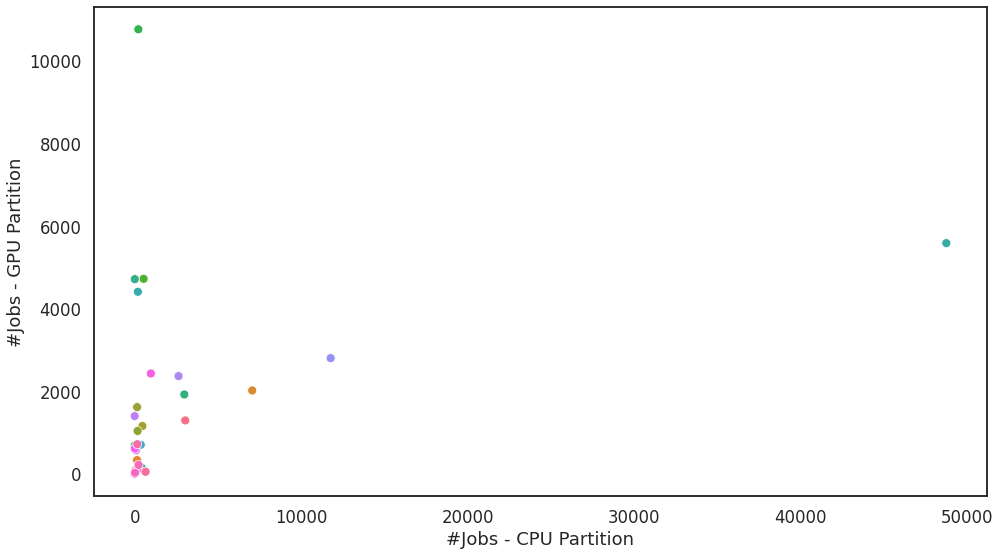

In [25]:
g = sns.scatterplot(x=jobs_by_user["cpu"], y=jobs_by_user["gpu"], hue=jobs_by_user.index, legend=False)
g.set_xlabel("#Jobs - CPU Partition")
g.set_ylabel("#Jobs - GPU Partition")

plt.savefig("scatter_users_cpu_gpu.pdf", bbox_inches="tight")

In [26]:
runtime_by_user = pd.crosstab(index=df["User"], columns=df["Partition"], values=df["Elapsed-H"], aggfunc="sum")

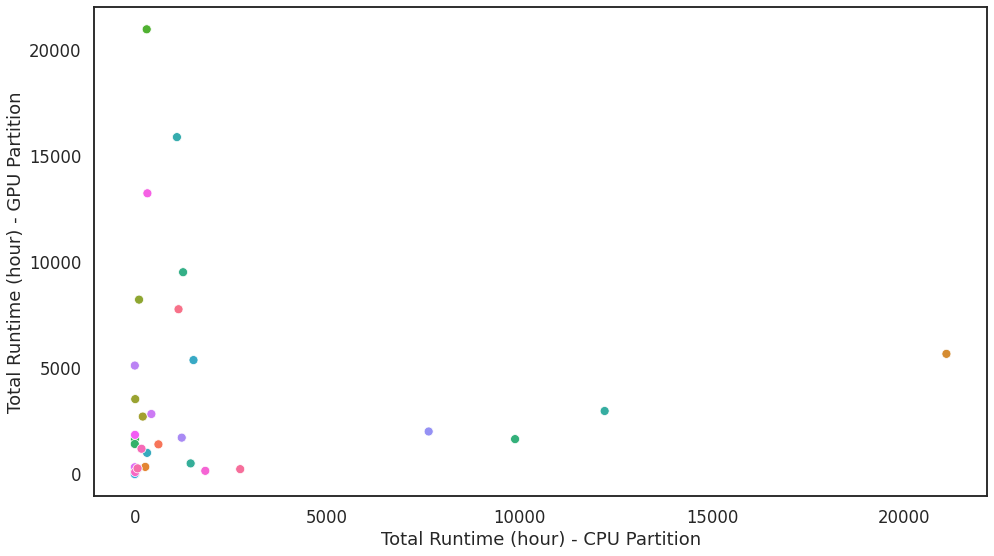

In [27]:
g = sns.scatterplot(x=runtime_by_user["cpu"], y=runtime_by_user["gpu"], hue=runtime_by_user.index, legend=False)

g.set_xlabel("Total Runtime (hour) - CPU Partition")
g.set_ylabel("Total Runtime (hour) - GPU Partition")

plt.savefig("scatter_users_runtime_per_partition.pdf", bbox_inches="tight")

# Number of Allocated CPUs

Mostly, jobs get 2 CPUs allocated.

In [28]:
by_ncpus = df.groupby("CPUCat")["count"].sum()

Text(0.5, 1.0, 'All Partitions')

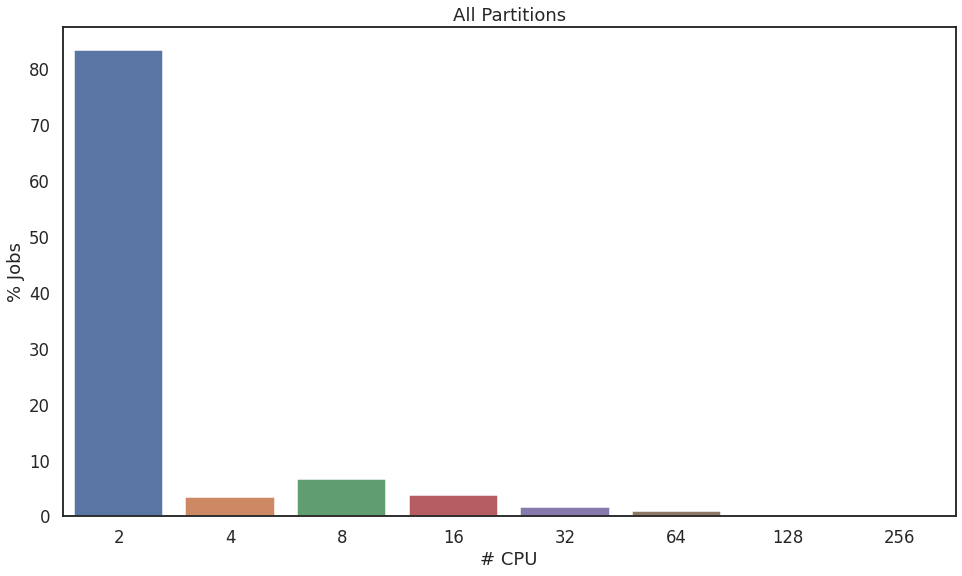

In [29]:
g = sns.barplot(x=by_ncpus.index, y=by_ncpus, estimator=lambda x: 100.0 * sum(x) / by_ncpus.sum())
g.set_xlabel("# CPU")
g.set_ylabel("% Jobs")
g.set_title("All Partitions")

In [30]:
by_partition_ncpus = df.groupby(["Partition", "CPUCat"])["count"].sum().loc[["cpu", "gpu"]].reset_index(level="CPUCat")

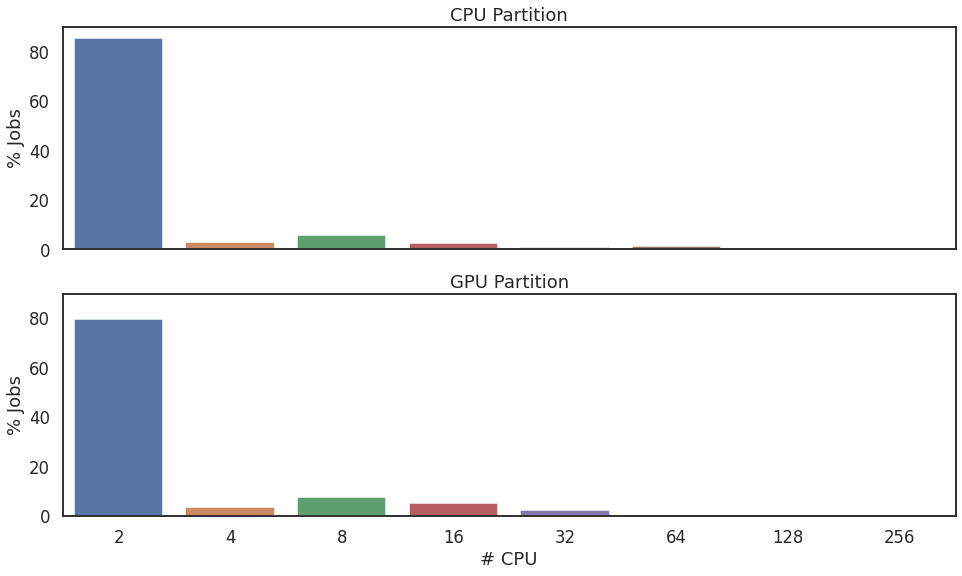

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)

for part, ax in zip(by_partition_ncpus.index.unique(), axs):
    part_data = by_partition_ncpus.loc[part]
    g = sns.barplot(x="CPUCat", y="count", data=part_data, ax=ax, estimator=lambda x: 100.0 * sum(x) / part_data["count"].sum())
    g.set_ylabel("% Jobs")
    g.set_title(f"{part.upper()} Partition")

axs[0].set_xlabel("")
axs[1].set_xlabel("# CPU")

fig.savefig("nb_cpus_per_job_per_partition.pdf", bbox_inches="tight")

# CPU vs RAM in CPU Partition

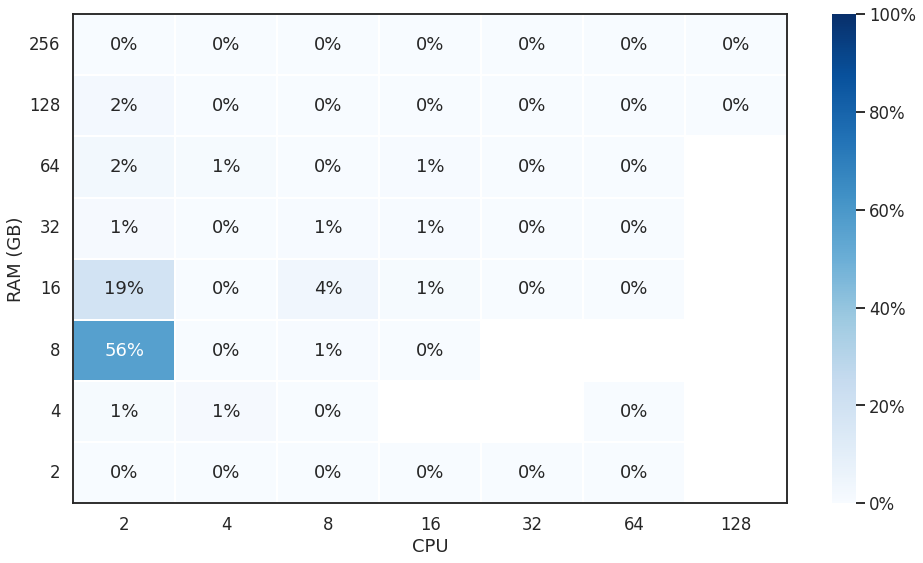

In [32]:
focus = df[df["Partition"] == "cpu"]
pivot = focus.pivot_table(index="RAMCat", columns="CPUCat", values="count", aggfunc=lambda x: np.sum(x) / focus.shape[0])

g = sns.heatmap(data=pivot, cmap="Blues", annot=True, fmt=".0%", cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, vmin=0.0, vmax=1.0, linewidth=2)

g.invert_yaxis()
g.set_yticklabels(g.get_yticklabels(), rotation=0)
g.set_xlabel("CPU")
g.set_ylabel("RAM (GB)")

for _, spine in g.spines.items():
    spine.set_visible(True)

plt.savefig("heatmap_cpu_ram_CPU_partition.pdf", bbox_inches="tight")

# Number of Allocated GPUs

In [33]:
by_ngpus = df.groupby(["Partition", "GPUCat"])["count"].sum().loc["gpu"]

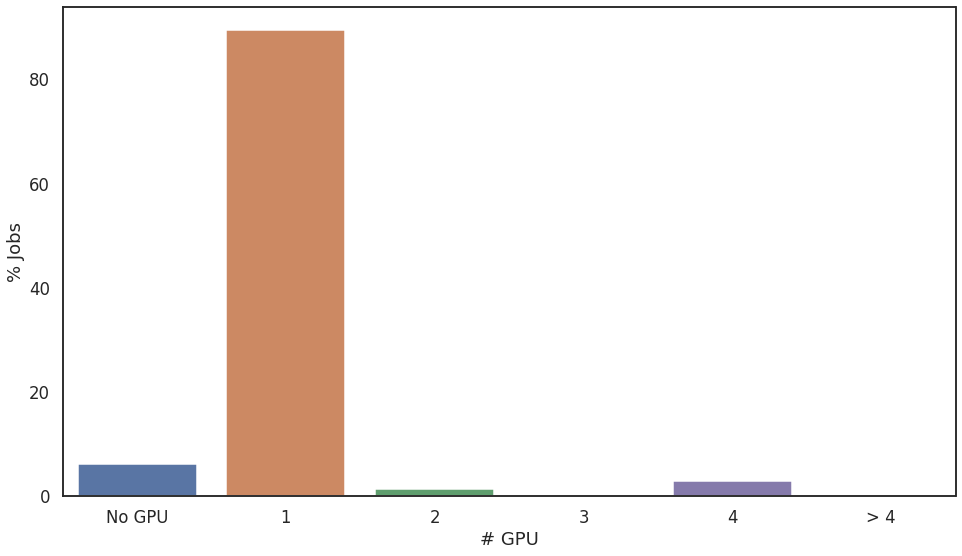

In [34]:
g = sns.barplot(x=by_ngpus.index, y=by_ngpus, estimator=lambda x: 100.0 * sum(x) / by_ngpus.sum())
g.set_xlabel("# GPU")
g.set_ylabel("% Jobs")

plt.savefig("gpu_per_job_GPU_partition.pdf", bbox_inches="tight")

# GPU vs CPU Usage in GPU Partition

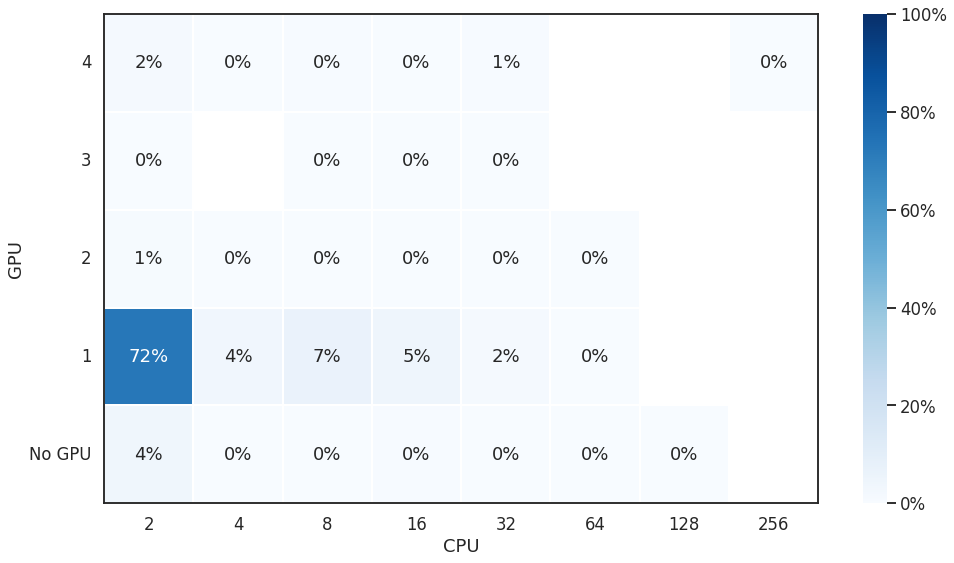

In [35]:
focus = df[(df["Partition"] == "gpu") & (df["AllocatedGPUs"] <= 4)]
pivot = focus.pivot_table(index="GPUCat", columns="CPUCat", values="count", aggfunc=lambda x: np.sum(x) / focus.shape[0])

g = sns.heatmap(data=pivot, cmap="Blues", annot=True, fmt=".0%", cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, vmin=0.0, vmax=1.0, linewidth=2)

g.invert_yaxis()
g.set_yticklabels(g.get_yticklabels(), rotation=0)
g.set_xlabel("CPU")
g.set_ylabel("GPU")

for _, spine in g.spines.items():
    spine.set_visible(True)

plt.savefig("heatmap_cpu_gpu_GPU_partition.pdf", bbox_inches="tight")

# Typical Week

In [36]:
by_day = df.groupby(["Date", "Day"])["count"].sum().reset_index()

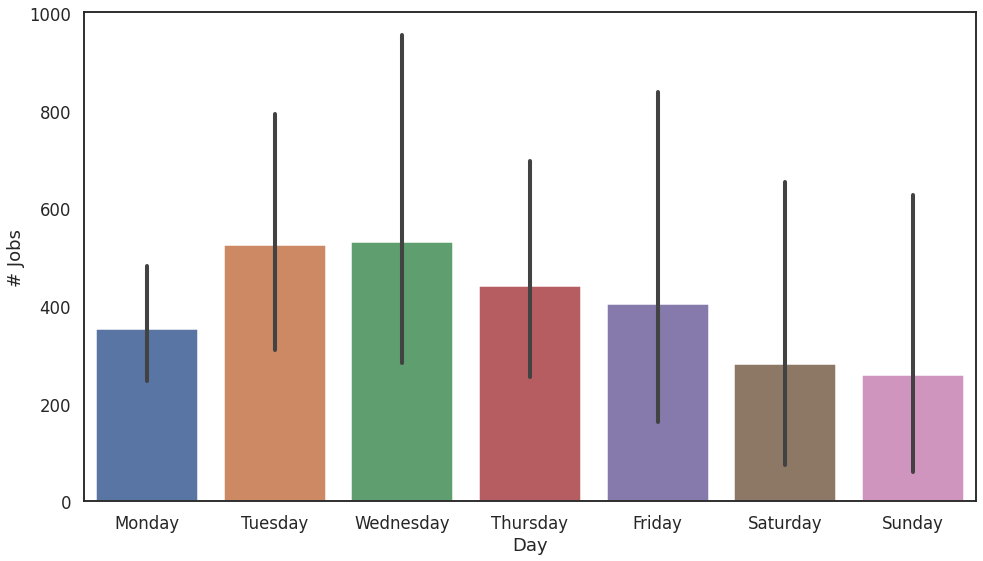

In [37]:
g = sns.barplot(x="Day", y="count", data=by_day, order=days)
g.set_ylabel("# Jobs")

plt.savefig("typical_week.pdf", bbox_inches="tight")

# Typical Day

In [38]:
by_hour_of_day = df.groupby([df["Start"].dt.floor(freq="D"), df["Start"].dt.hour])["count"].sum()
by_hour_of_day.index.rename(["Date", "Hour"], inplace=True)

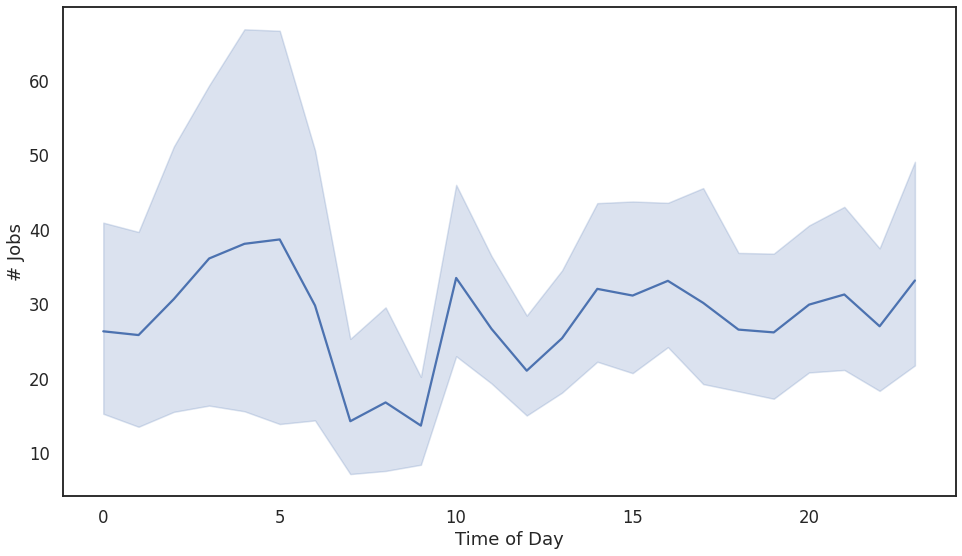

In [39]:
g = sns.lineplot(data=by_hour_of_day.reset_index(), x="Hour", y="count")
g.set_xlabel("Time of Day")
g.set_ylabel("# Jobs")

plt.savefig("typical_day.pdf", bbox_inches="tight")

# Per Weekday

Wrong graph, as it gets the mean over different number of samples, as days/hours with 0 job do not appear

In [40]:
by_dayname_and_hour = df.groupby(["Date", "Day", "Hour"])["count"].sum()
by_dayhour = by_dayname_and_hour.groupby(["Day", "Hour"]).mean()

In [41]:
hours = [6, 12, 18]
hours_labels = [f"{h:02d}:00" for h in hours]

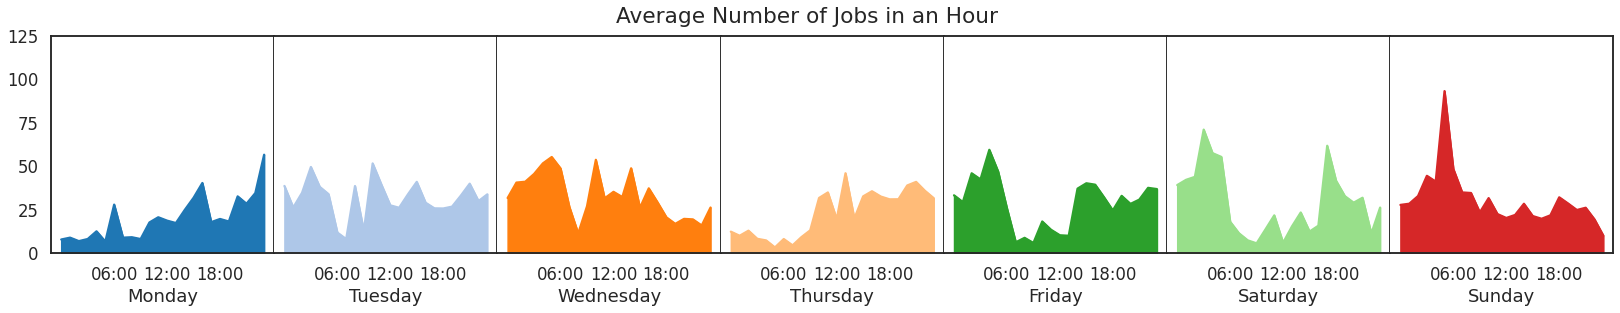

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(28, 4), sharey=True)

for i, ax in enumerate(axs):
    by_dayhour[by_dayhour.index.get_level_values("Day") == days[i]].plot.area(ax=ax, xticks=hours, color=days_colors[days[i]], xlabel=days[i], ylim=(0, 125)) 
    ax.set_xticklabels(hours_labels)
    if i > 0:
        ax.spines["left"].set_visible(False)
        ax.tick_params(left=False)
    
plt.subplots_adjust(wspace=0, hspace=0)
_ = fig.suptitle("Average Number of Jobs in an Hour")

plt.savefig("week_per_dayhour.pdf", bbox_inches="tight")

In [43]:
# Anomaly on Sunday night explained by hyperactivity on October 3
by_dayname_and_hour.loc[:, "Sunday", 6]

Date
2021-03-14      1
2021-05-16      4
2021-07-18     30
2021-09-12      3
2021-10-03    374
2021-10-31      2
2021-11-07      1
2021-12-05      5
2021-12-12     16
Name: count, dtype: int64

# Other by weekday

In [44]:
pivot = df.pivot_table(index="Day", columns="Hour", values="count", aggfunc="sum")

In [45]:
pivot = pivot.reindex(days)

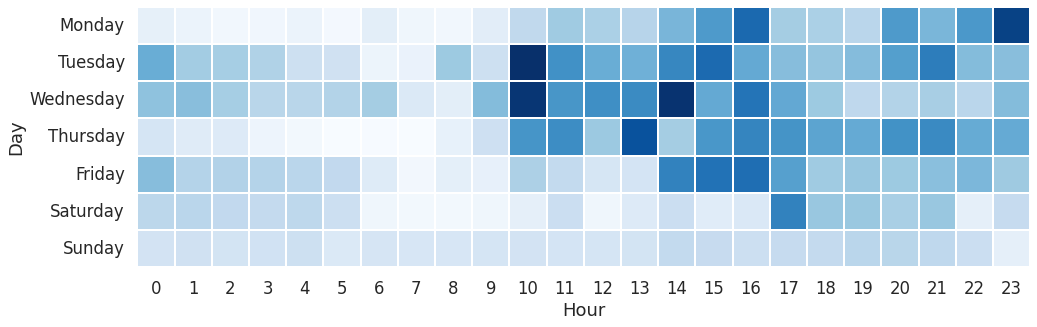

In [46]:
sns.heatmap(data=pivot, cmap="Blues", linewidth=2, cbar=False, square=True) 
plt.savefig("heatmap_weekday_hour.pdf", bbox_inches="tight")

# Jobs Status

In [47]:
by_state = df.groupby("StateTag")["count"].sum()

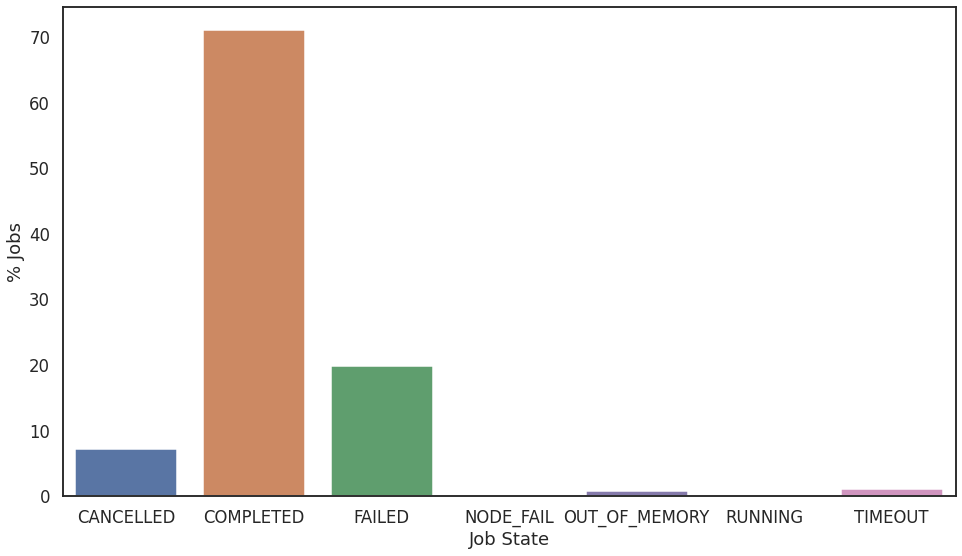

In [48]:
g = sns.barplot(x=by_state.index, y=by_state, estimator=lambda x: 100.0 * sum(x) / by_state.sum())
g.set_xlabel("Job State")
g.set_ylabel("% Jobs")

plt.savefig("job_status.pdf", bbox_inches="tight")

# Job Submission through 2021

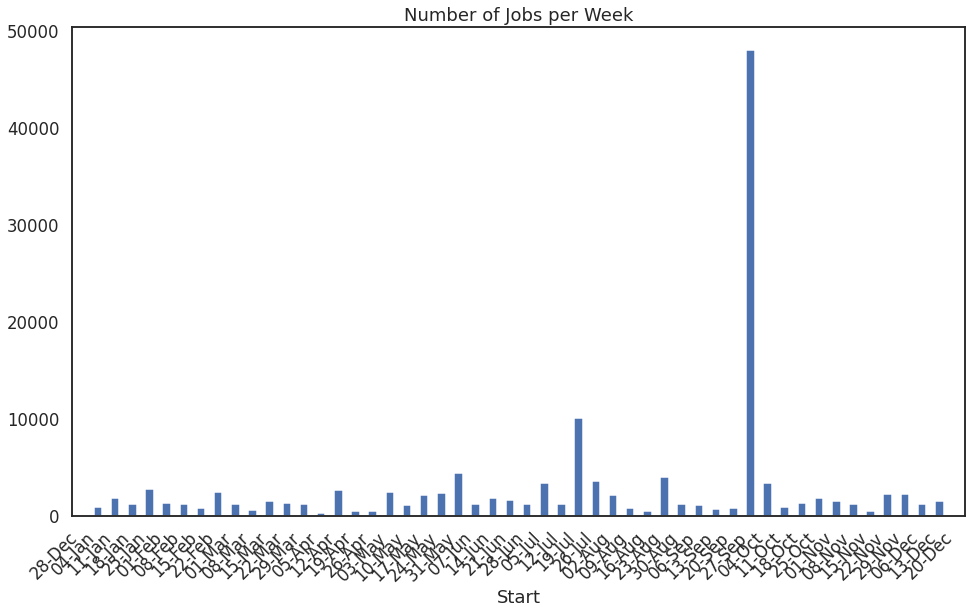

In [49]:
by_week = df.groupby(df["Start"].dt.to_period("W").dt.to_timestamp()).count()["JobID"]
by_week.plot.bar(figsize=(16,9))
ax = plt.gca()
_ = ax.set_xticklabels(by_week.index.strftime("%d-%b"), rotation=45, ha="right")
_ = plt.title("Number of Jobs per Week")

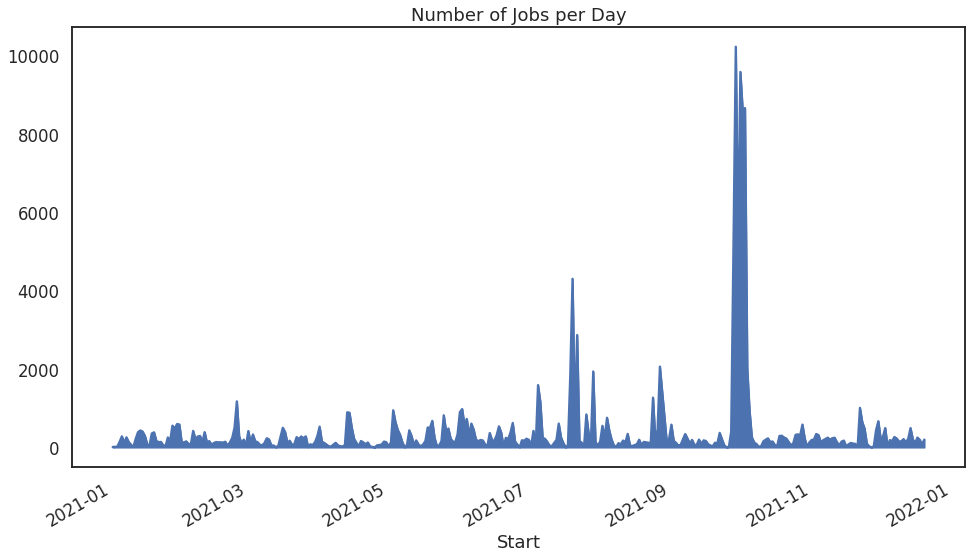

In [50]:
df.groupby(df["Start"].dt.floor(freq="D")).count()["JobID"].plot.area(figsize=(16,9))
_ = plt.title("Number of Jobs per Day")

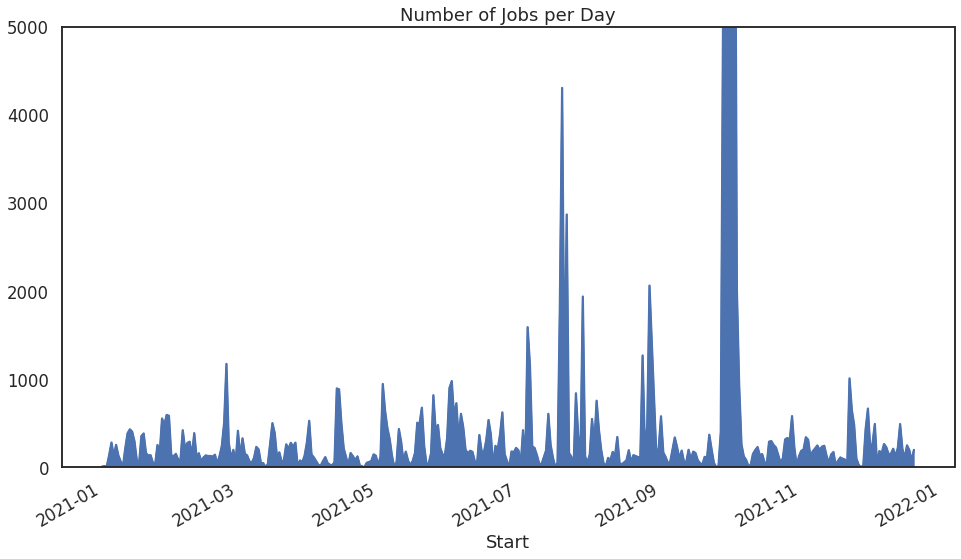

In [51]:
df.groupby(df["Start"].dt.floor(freq="D")).count()["JobID"].plot.area(figsize=(16,9), ylim=(0, 5000))
_ = plt.title("Number of Jobs per Day")
plt.savefig("job_per_day.pdf", bbox_inches="tight")

# Jobs per Node

In [52]:
single_node_jobs = df[df["NodeList"].str.len() == 10].copy()
by_partition_node = single_node_jobs.groupby(["Partition", "NodeList"]).count()["JobID"]

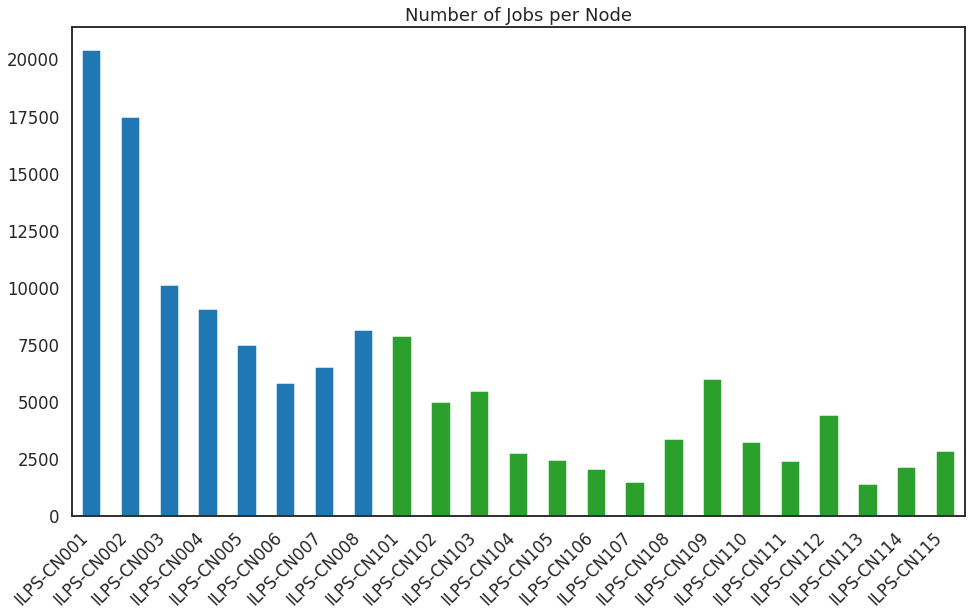

In [53]:
by_partition_node.plot.bar(color=[partitions_colors[p] for p in by_partition_node.index.get_level_values("Partition")], xlabel="")
_ = plt.gca().set_xticklabels(by_partition_node.index.get_level_values("NodeList").str.upper(), rotation=45, ha="right")
_ = plt.title("Number of Jobs per Node")
plt.savefig("job_per_node.pdf", bbox_inches="tight")

# Job Time per Node

In [54]:
activity_by_node = single_node_jobs.groupby(["Partition", "NodeList"])["Elapsed-S"].sum()

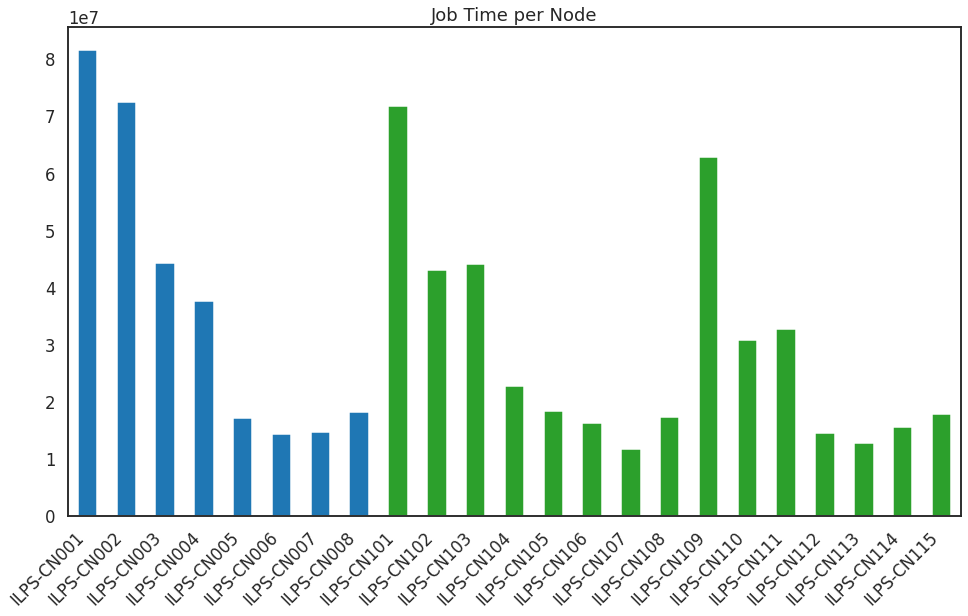

In [55]:
activity_by_node.dt.total_seconds().plot.bar(color=[partitions_colors[p] for p in activity_by_node.index.get_level_values("Partition")], xlabel="")
_ = plt.gca().set_xticklabels(by_partition_node.index.get_level_values("NodeList").str.upper(), rotation=45, ha="right")
_ = plt.title("Job Time per Node")
plt.savefig("job_runtime_per_node.pdf", bbox_inches="tight")

# Capacity

* CPU Node: number of CPU * time
* GPU Node: number of GPU * time

In [56]:
cluster = pd.read_csv("cluster.csv")

In [57]:
cluster = cluster.fillna(0)

def nb_gpus(x):
    if isinstance(x, str):
        return int(x.strip()[-1])
    return int(x)

cluster["NbGPU"] = cluster["GRES"].apply(nb_gpus)

In [58]:
collection_date = pd.Timestamp("2021-10-08 00:00:00")
year_begin = collection_date + pd.offsets.YearBegin(-1)

delta = collection_date - year_begin

In [59]:
def capacity(x):
    if x["PARTITION"] == "cpu":
        return delta.total_seconds() * x["CPUS"]
    elif x["PARTITION"] == "gpu":
        return delta.total_seconds() * x["NbGPU"]

In [60]:
cluster["Capacity"] = cluster.apply(capacity, axis=1)

# Job Time relative to Node Capacity

In [61]:
def adjustment(x):
    if x["Partition"] == "cpu":
        return x["NCPUS"]
    elif x["Partition"] == "gpu":
        return x["AllocatedGPUs"]   # if no GPU allocated but running on a GPU node, it counts as 0
    
single_node_jobs["AdjustmentMultiplier"] = single_node_jobs.apply(adjustment, axis=1)

In [62]:
single_node_jobs["AdjustedRuntime"] = single_node_jobs["Elapsed-S"] * single_node_jobs["AdjustmentMultiplier"]
adjusted_activity_by_node = single_node_jobs.groupby(["Partition", "NodeList"])["AdjustedRuntime"].sum()

In [63]:
df_activity = pd.DataFrame(adjusted_activity_by_node.dt.total_seconds())
df_capacity = pd.DataFrame(cluster.set_index(["PARTITION", "HOSTNAMES"])["Capacity"])

In [64]:
new_index = ["Partition", "Node"]
df_activity.index.rename(new_index, inplace=True)
df_capacity.index.rename(new_index, inplace=True)

In [65]:
join = df_activity.join(df_capacity)

In [66]:
join["Usage"] = 100.0 * join["AdjustedRuntime"] / join["Capacity"]

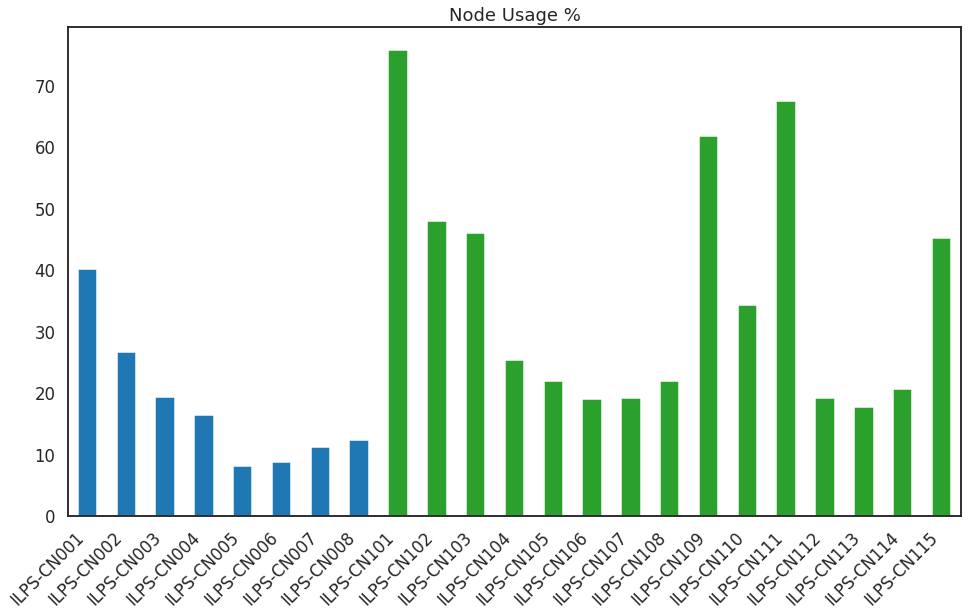

In [67]:
join["Usage"].plot.bar(color=[partitions_colors[p] for p in activity_by_node.index.get_level_values("Partition")], xlabel="")
_ = plt.gca().set_xticklabels(join.index.get_level_values("Node").str.upper(), rotation=45, ha="right")
_ = plt.title("Node Usage %")

plt.savefig("node_usage.pdf", bbox_inches="tight")

# RAM Usage

* steps have no User
* JobID is <jobid>_<step_idx>.(batch|extern)
* Resources are accounted on *.batch
    
Target:
* reconcile the row with jobid "*.batch" with the row with same jobid so we have one raw with MaxRSS indicated
   

In [68]:
original.head()

,User,JobID,JobName,JobIDRaw,Partition,State,Timelimit,Submit,Start,End,Elapsed,MaxRSS,MaxVMSize,NNodes,NCPUS,NodeList,AllocTRES,TotalCPU
0,vprovat,54631,mongo.job,54631,cpu,CANCELLED by 200061021,21-16:00:00,2020-12-17T17:36:49,2020-12-17T17:36:49,2021-01-03T17:24:38,16-23:47:49,NaN,NaN,1,8,ilps-cn001,"billing=8,cpu=8,mem=32G,node=1",06:06:02
1,NaN,54631.batch,batch,54631.batch,NaN,CANCELLED,NaN,2020-12-17T17:36:49,2020-12-17T17:36:49,2021-01-03T17:24:45,16-23:47:56,2.25G,0.17G,1,8,ilps-cn001,"cpu=8,mem=32G,node=1",06:06:02
2,NaN,54631.extern,extern,54631.extern,NaN,COMPLETED,NaN,2020-12-17T17:36:49,2020-12-17T17:36:49,2021-01-03T17:24:38,16-23:47:49,0,0.10G,1,8,ilps-cn001,"billing=8,cpu=8,mem=32G,node=1",00:00.002
3,vprovat,55148,run_more_crawlers.job,55148,cpu,CANCELLED by 200061021,17-07:00:00,2020-12-20T20:13:37,2020-12-20T20:13:37,2021-01-03T17:24:21,13-21:10:44,NaN,NaN,1,32,ilps-cn002,"billing=32,cpu=32,mem=48G,node=1",1-23:25:06
4,NaN,55148.batch,batch,55148.batch,NaN,CANCELLED,NaN,2020-12-20T20:13:37,2020-12-20T20:13:37,2021-01-03T17:24:33,13-21:10:56,26.14G,0.17G,1,32,ilps-cn002,"cpu=32,mem=48G,node=1",1-23:25:06


In [69]:
original["AllocatedRAM"] = original["AllocTRES"].apply(amount_ram)
original["UsedCPU"] = pd.to_timedelta(original["TotalCPU"].apply(normalize)).dt.total_seconds()
original["AllocatedCPUTime"] = original["NCPUS"] * original["NNodes"] * pd.to_timedelta(original["Elapsed"].apply(normalize)).dt.total_seconds()

In [70]:
re_job = re.compile(r"^(?P<jobid>\d+(_\d+)?)$")
re_batch = re.compile(r"^(?P<jobid>\d+(_\d+)?)\.batch$")

def is_job(jobid):
    return re_job.match(jobid) is not None
    
def is_batch(jobid):
    return re_batch.match(jobid) is not None

In [71]:
jobs = original[(original["JobID"].apply(is_job)) & (original["State"] != "OUT_OF_MEMORY")][["User", "JobID", "UsedCPU", "AllocatedCPUTime", "NCPUS"]]
batchs = original[original["JobID"].apply(is_batch)][["JobID", "MaxRSS", "AllocatedRAM"]].dropna(axis=0, subset=["MaxRSS"])

In [72]:
batchs.head()

,JobID,MaxRSS,AllocatedRAM
1,54631.batch,2.25G,32
4,55148.batch,26.14G,48
7,55160.batch,47.84G,48
10,55161.batch,22.23G,32
13,55162.batch,24.66G,32


In [73]:
jobs.head()

,User,JobID,UsedCPU,AllocatedCPUTime,NCPUS
0,vprovat,54631,21962.0,11744552.0,8
3,vprovat,55148,170706.0,38382208.0,32
6,vprovat,55160,1109719.0,38346880.0,32
9,vprovat,55161,180011.0,38345504.0,32
12,vprovat,55162,196487.0,19172512.0,16


In [74]:
def rss_str_to_float(rss):
    if len(rss) == 1:
        return 0.0
    return float(rss[:-1])

batchs["UsedRAM"] = batchs["MaxRSS"].apply(rss_str_to_float)

In [75]:
jobs["idx_job"] = jobs["JobID"]

In [76]:
def batchid_to_jobid(batchid):
    m = re_batch.match(batchid)
    return m.group("jobid")

batchs["idx_job"] = batchs["JobID"].apply(batchid_to_jobid)

In [77]:
joined = jobs.set_index("idx_job").join(batchs.set_index("idx_job"), how="inner", lsuffix=".batch", rsuffix=".job")

In [78]:
joined["RAM_pct"] = joined["UsedRAM"] / joined["AllocatedRAM"]
joined["RAM_pct"] = joined["RAM_pct"].replace([np.inf, -np.inf], np.nan)

In [79]:
joined.head()

,User,JobID.batch,UsedCPU,AllocatedCPUTime,NCPUS,JobID.job,MaxRSS,AllocatedRAM,UsedRAM,RAM_pct
idx_job,,,,,,,,,,
54631,vprovat,54631,21962.0,11744552.0,8,54631.batch,2.25G,32,2.25,0.070312
55148,vprovat,55148,170706.0,38382208.0,32,55148.batch,26.14G,48,26.14,0.544583
55160,vprovat,55160,1109719.0,38346880.0,32,55160.batch,47.84G,48,47.84,0.996667
55161,vprovat,55161,180011.0,38345504.0,32,55161.batch,22.23G,32,22.23,0.694688
55162,vprovat,55162,196487.0,19172512.0,16,55162.batch,24.66G,32,24.66,0.770625


<AxesSubplot:xlabel='RAM_pct', ylabel='Density'>

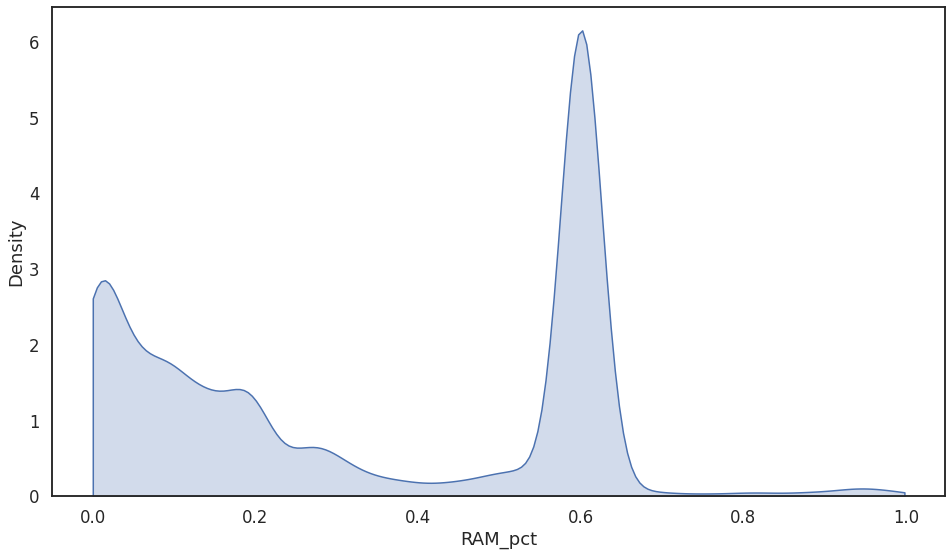

In [80]:
sns.kdeplot(x="RAM_pct", data=joined.dropna(), fill=True, cut=0)


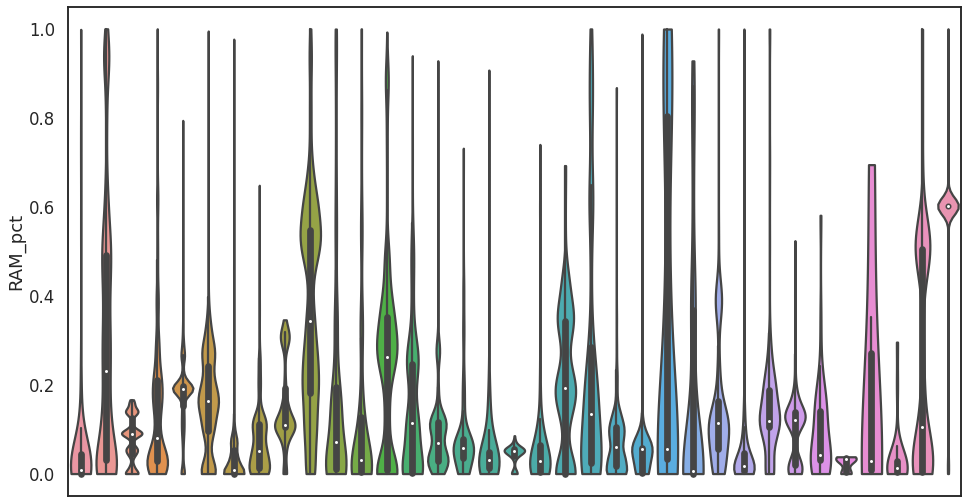

In [81]:
sns.violinplot(x="User", y="RAM_pct", data=joined.dropna(), cut=0, scale="width")
plt.xlabel("")
plt.xticks([])

plt.savefig("violin_ram_usage_per_user.pdf", bbox_inches="tight")

In [82]:
joined["CPU_pct"] = joined["UsedCPU"] / joined["AllocatedCPUTime"]
joined["CPU_pct"] = joined["CPU_pct"].replace([np.inf, -np.inf], np.nan)

In [83]:
bins = [2 ** i for i in range(9)]
labels= [str(b) for b in bins[1:]]
joined["CpuSize"] = pd.cut(joined["NCPUS"], bins=bins, labels=labels)

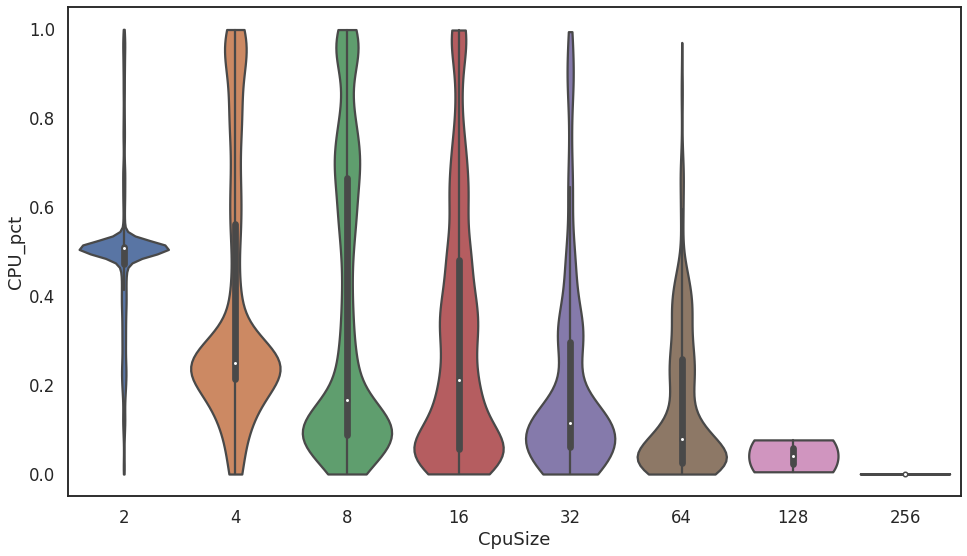

In [84]:
sns.violinplot(x="CpuSize", y="CPU_pct", data=joined.dropna(), fill=True, cut=0, scale="width")
plt.savefig("violin_cpu_usage_per_cpusize.pdf", bbox_inches="tight")

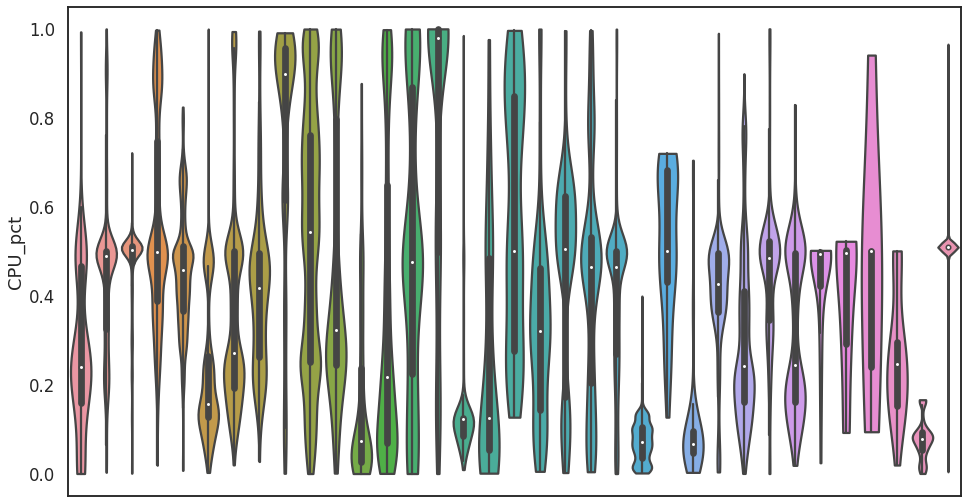

In [85]:
sns.violinplot(x="User", y="CPU_pct", data=joined.dropna(), fill=True, cut=0, scale="width")
plt.xlabel("")
plt.xticks([])
plt.savefig("violin_cpu_usage_per_user.pdf", bbox_inches="tight")

# Calendar (do it LAST, it breaks all seaborn / matplotlib theme)

Clipped to 500 jobs started, as some rare peak days tale over (2x10k, 2x5k)

In [86]:
import july

In [87]:
by_date = df.groupby("Date")["count"].sum()

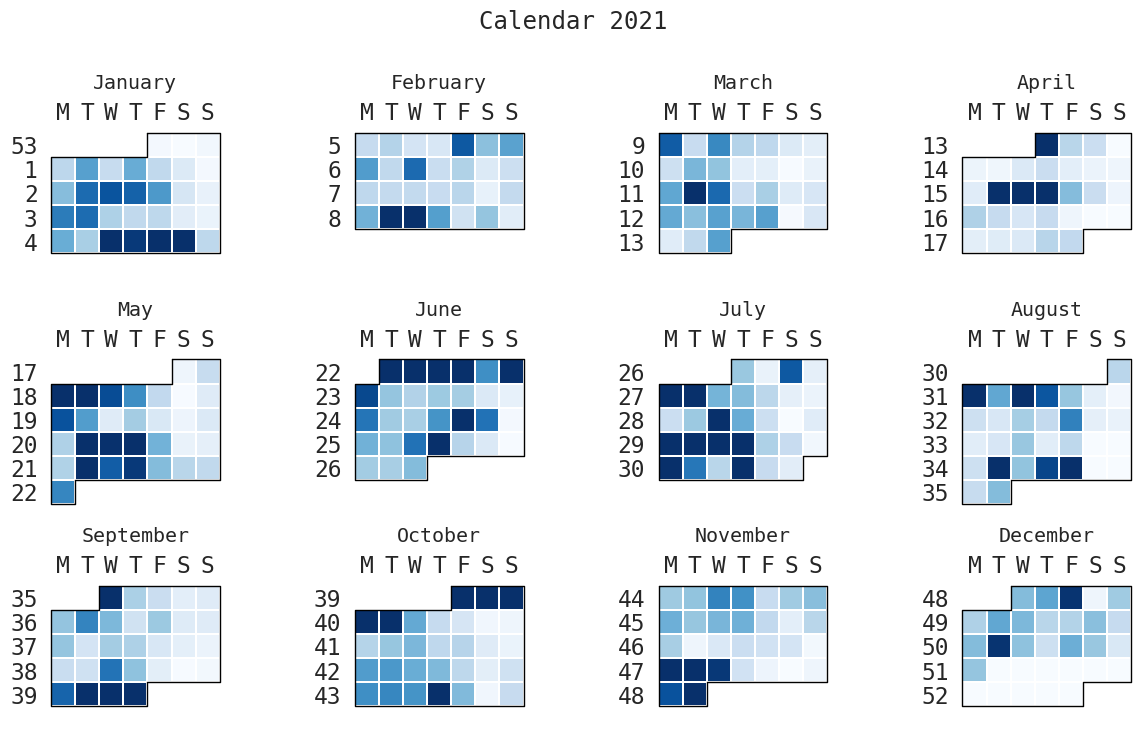

In [88]:
g = july.calendar_plot(dates=by_date.index, data=by_date, title='# Jobs', cmap="Blues")
for ax in g.flatten():
    if len(ax.collections) == 1:
        ax.collections[0].set_clim(0, 500)

plt.savefig("calendar.pdf", bbox_inches="tight")